Start: (226, 147)  End: (428, 95)


/home/donggun/venv/pathplanning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/donggun/venv/pathplanning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/donggun/venv/pathplanning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/donggun/venv/pathplanning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/donggun/venv/pathplanning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (

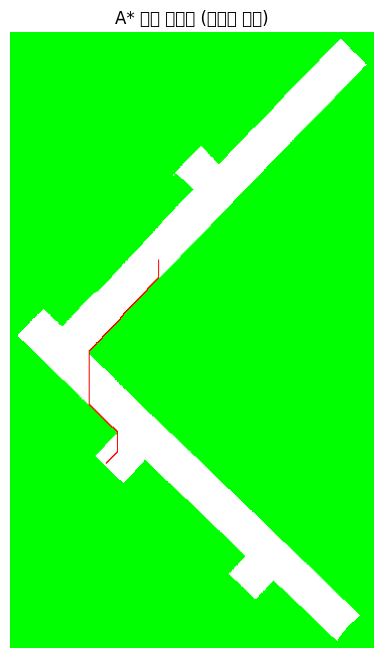

In [ ]:
import cv2
import yaml
import sys
import numpy as np
import matplotlib.pyplot as plt
import random

def pixel_cost_map(img):
    """
    각 픽셀 단위로 맵을 0, 1, 2의 cost로 변환
    - 0: 이동 가능 (노란색 등 밝은 영역)
    - 1: 이동 불가 (초록색, 회색 등 어두운 영역)
    - 2: 벽 (완전한 검정색)
    """
    height, width = img.shape[:2]
    cost_map = np.zeros((height, width), dtype=np.uint8)

    for y in range(height):
        for x in range(width):
            pixel = img[y, x]

            # Grayscale 이미지일 경우
            if len(pixel.shape) == 0 or isinstance(pixel, np.uint8):
                intensity = pixel
            else:
                # Color 이미지일 경우 (BGR)
                b, g, r = pixel
                intensity = int(0.299*r + 0.587*g + 0.114*b)  # convert to grayscale intensity
            
            if intensity <= 30:
                cost_map[y, x] = 1  # 벽 (검정)
            elif intensity <= 210:
                cost_map[y, x] = 1  # 이동 불가
            else:
                cost_map[y, x] = 0  # 이동 가능

    return cost_map


# 지도 이미지 로드
pgm_img = cv2.imread('./map.pgm', cv2.IMREAD_GRAYSCALE)

# PNG로 저장
cv2.imwrite('./map.png', pgm_img)
map_img = cv2.imread('./map.png', cv2.COLOR_BGR2GRAY)


cost_map = pixel_cost_map(map_img)

# === 출발점과 도착점 자동 설정 함수 ===
def find_start_end(cost_map):
    candidates = []

    for i in range(len(cost_map)):
        for j in range(len(cost_map[0])):
            if cost_map[i][j] == 0:
                candidates.append((i, j))

    if len(candidates) < 2:
        raise ValueError("이동 가능한 위치가 2개 이상 필요합니다.")

    start = random.choice(candidates)
    candidates.remove(start)
    end = random.choice(candidates)

    return start, end


# === 시각화 함수 ===
def visualize_path(cost_map, path):
    img = np.array(cost_map)

    # 색상 맵: 0 = 흰색, 1 = 초록, 2 = 검정
    color_map = {
        0: [255, 255, 255],   # 이동 가능 → 흰색
        1: [0, 255, 0],       # 이동 불가 → 초록
        2: [0, 0, 0],         # 벽 → 검정
    }

    # RGB 이미지로 변환
    rgb_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for key, color in color_map.items():
        rgb_img[img == key] = color

    # 경로 표시 (빨간색)
    for pos in path:
        rgb_img[pos[0], pos[1]] = [255, 0, 0]  # 빨간색

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_img)
    plt.title("A* 경로 시각화 (빨간색 경로)")
    plt.axis('off')
    plt.show()

class Astar:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    def heuristic(self, node, goal, D=1, D2=2 ** 0.5):  # Diagonal Distance
        dx = abs(node.position[0] - goal.position[0])
        dy = abs(node.position[1] - goal.position[1])
        return D * (dx + dy)


    def aStar(self, maze, start, end):
        # startNode와 endNode 초기화
        startNode = Astar(None, start)
        endNode = Astar(None, end)

        # openList, closedList 초기화
        openList = []
        closedList = []

        # openList에 시작 노드 추가
        openList.append(startNode)

        # endNode를 찾을 때까지 실행
        while openList:

            # 현재 노드 지정
            currentNode = openList[0]
            currentIdx = 0

            # 이미 같은 노드가 openList에 있고, f 값이 더 크면
            # currentNode를 openList안에 있는 값으로 교체
            for index, item in enumerate(openList):
                if item.f < currentNode.f:
                    currentNode = item
                    currentIdx = index

            # openList에서 제거하고 closedList에 추가
            openList.pop(currentIdx)
            closedList.append(currentNode)

            # 현재 노드가 목적지면 current.position 추가하고
            # current의 부모로 이동
            if currentNode == endNode:
                path = []
                current = currentNode
                while current is not None:
                    # maze 길을 표시하려면 주석 해제
                    x, y = current.position
                    maze[x][y] = 2
                    path.append(current.position)
                    current = current.parent
                return path[::-1]  # reverse

            children = []
            # 인접한 xy좌표 전부
            for newPosition in [(0, -1), (0, 1), (-1, 0), (1, 0)]:

                # 노드 위치 업데이트
                nodePosition = (
                    currentNode.position[0] + newPosition[0],  # X
                    currentNode.position[1] + newPosition[1])  # Y
                    
                # 미로 maze index 범위 안에 있어야함
                within_range_criteria = [
                    nodePosition[0] > (len(maze) - 1),
                    nodePosition[0] < 0,
                    nodePosition[1] > (len(maze[len(maze) - 1]) - 1),
                    nodePosition[1] < 0,
                ]

                if any(within_range_criteria):  # 하나라도 true면 범위 밖임
                    continue

                # 장애물이 있으면 다른 위치 불러오기
                if maze[nodePosition[0]][nodePosition[1]] != 0:
                    continue

                new_node = Astar(currentNode, nodePosition)
                children.append(new_node)

            # 자식들 모두 loop
            for child in children:

                # 자식이 closedList에 있으면 continue
                if child in closedList:
                    continue

                # f, g, h값 업데이트
                child.g = currentNode.g + 1
                child.h = ((child.position[0] - endNode.position[0]) **
                        2) + ((child.position[1] - endNode.position[1]) ** 2)
                # child.h = heuristic(child, endNode) 다른 휴리스틱
                # print("position:", child.position) 거리 추정 값 보기
                # print("from child to goal:", child.h)
                
                child.f = child.g + child.h

                # 자식이 openList에 있으고, g값이 더 크면 continue
                if len([openNode for openNode in openList
                        if child == openNode and child.g > openNode.g]) > 0:
                    continue
                        
                openList.append(child)

    def run(self, maze, start, end):
        path = self.aStar(maze, start, end)
        return maze, path

make_route = Astar()
# 출발점과 도착점 자동 탐색
start, end = find_start_end(cost_map)
print("Start:", start, " End:", end)
start = (320, 42)
end = (200, 153)
# 경로 생성
result, path = make_route.run(cost_map, start, end)

# 시각화
visualize_path(result, path)



In [49]:
print(start)

(335, 42)


In [50]:
print(end)

(200, 153)
